# Preparation

## Import Libraries

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns
import albumentations as A

## Set Arguments & hyperparameters

In [2]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '/USER/data'
NUM_CLS = 2

EPOCHS = 10
BATCH_SIZE = 17
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 384
K_FOLDS = 5

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# check device
DEVICE

device(type='cuda')

In [4]:
# Set Augmentation variable
VFLIP = True
HFLIP = True
ROTATE = True
FLIP_ROTATE = True
COARCE_DROPOUT = True
ANGLE = None

## Data Augmetation

이미지 로드 완료


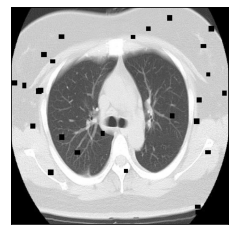

In [6]:
import matplotlib.pyplot as plt
img = cv2.imread(f'{DATA_DIR}/train/1.png')

print("이미지 로드 완료")

transform = A.Compose([
    A.CoarseDropout(always_apply=False, p=1, max_holes=50, max_height=10, max_width=10, min_holes=20, min_height=7, min_width=7),
])
coarce_img = transform(image=img)['image']
plt.imshow(coarce_img)
plt.xticks([]); plt.yticks([])
plt.show()

In [14]:
# ./data/augmentation 위치에 이미지를 생성하도록 만듦
# vflip : 상하로 뒤집을건지, hflip : 좌우로 뒤집을건지, rotate : 회전을 할건지 (한다면) angle : 지정한값으로 할건지(비우면 random)
def createimage(vflip=True, hflip=True, rotate=True, flip_rotate=True, coarce_dropout=True, angle=None):
    origin_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
    origin_df = origin_df[:645]

    # save original image
    for i in tqdm(range(645)):
        img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
        cv2.imwrite(f'{DATA_DIR}/augmentation/{i}.png', img)
        

    # vertical flip
    if vflip:
        for i in tqdm(range(645)):
            img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
            vflip_img = cv2.flip(img, 0)
            cv2.imwrite(f'{DATA_DIR}/augmentation/{i}_vflip.png', vflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_vflip.png', origin_df.iloc[i]['COVID']]

        
    # horizontal filp
    if hflip:
        for i in tqdm(range(645)):
            img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            cv2.imwrite(f'{DATA_DIR}/augmentation/{i}_hflip.png', hflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_hflip.png', origin_df.iloc[i]['COVID']]

    # rotate
    if rotate:
        for i in tqdm(range(645)):
            img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
            h, w = img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            # rotate by random value(5 ~ 35)
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            cv2.imwrite(f'{DATA_DIR}/augmentation/{i}_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_rotate.png', origin_df.iloc[i]['COVID']]

    # flip-rotate
    if flip_rotate:
        for i in tqdm(range(645)):
            img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            h, w = hflip_img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            # rotate by random value
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            cv2.imwrite(f'{DATA_DIR}/augmentation/{i}_flip_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_flip_rotate.png', origin_df.iloc[i]['COVID']]
            
#     if coarce_dropout:
#         for i in tqdm(range(645)):
#             img = cv2.imread(f'{DATA_DIR}/train/{i}.png')
            
#             transform = A.Compose([
#                 A.CoarseDropout(always_apply=False, p=1, max_holes=50, max_height=10, max_width=10, min_holes=20, min_height=7, min_width=7),
#             ])
#             coarce_img = transform(image=img)['image']
#             cv2.imwrite(f'{DATA_DIR}/augmentation/{i}_coarce_dropout.png', coarce_img)
            
#             origin_df.loc[len(origin_df)] = [f'{i}_coarce_dropout.png', origin_df.iloc[i]['COVID']]

    print('\nsave csv file...')
    origin_df.to_csv(os.path.join(DATA_DIR, 'augmentation.csv'))
    print("ALL JOBS FINISHED")

    
    
    return origin_df

In [16]:
new_df = createimage(VFLIP, HFLIP, ROTATE, FLIP_ROTATE, COARCE_DROPOUT, ANGLE)

100% 645/645 [00:06<00:00, 105.58it/s]
100% 645/645 [00:06<00:00, 93.98it/s]
100% 645/645 [00:06<00:00, 94.04it/s] 
100% 645/645 [00:07<00:00, 82.63it/s]
100% 645/645 [00:07<00:00, 81.96it/s]


save csv file...
ALL JOBS FINISHED


# Define Dataloader

## Train & Validation Set loader

In [ ]:
class ValidationDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        
        # Dataset split
        self.db = self.db[578:]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            print(os.path.join(self.data_dir,'train',data['file_name']))
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID'], data['file_name']

In [ ]:
class CustomDataset(Dataset):
    ####################################################################
    ####          인자값에 mode 삭제 후 idx를 추가해줘야함          ####
    ####################################################################
    def __init__(self, data_dir, idx, input_shape):
        self.data_dir = data_dir
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.idx = idx
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.db = self.db.iloc[self.idx]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################        
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        ####################################################################
        ####          읽어올 label 정보 csv를 train에서 바꿔줌          ####
        ####################################################################
        db = pd.read_csv(os.path.join(self.data_dir, 'augmentation.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        ####################################################################
        ####           이미지를 읽어올 경로를 train에서 바꿔줌          ####
        ####################################################################
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        ####################################################################
        ####           리턴값에 data['file_name'] 추가해줘야함          ####
        ####################################################################
        return trans_image, data['COVID'], data['file_name']

# Define Model(VGG-16)

In [ ]:
from torchvision.models import vgg16


class VGG16(nn.Module):
    def __init__(self, NUM_CLS):
        super(VGG16, self).__init__()
        self.vgg = vgg16(pretrained=False)
        self.features_conv = self.vgg.features
        self.linear = nn.Sequential(
            nn.Linear(73728, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, NUM_CLS),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features_conv(x)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

## Utils
### EarlyStopper

In [ ]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [ ]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load model and other utils

In [ ]:
# Set optimizer, scheduler, loss function, metric function
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn

### K-Fold 학습 진행

In [ ]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [17]:
train_loss_list = [[] for _ in range(EPOCHS)]
val_loss_list = [[] for _ in range(EPOCHS)]

for fold, (train_idx, val_idx) in enumerate(kfold.split(range(578))):
    print(f'============================{fold+1}th fold============================')
    augmentations = 0
    length = len(train_idx)
    if VFLIP:
        augmentations += 1
        vflip_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, vflip_idx))
    if HFLIP:
        augmentations += 1
        hflip_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, hflip_idx))
    if ROTATE:
        augmentations += 1
        rotate_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, rotate_idx))
    if FLIP_ROTATE:
        augmentations += 1
        frotate_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, frotate_idx))

    train_dataset = CustomDataset(data_dir=DATA_DIR, idx=train_idx, input_shape=INPUT_SHAPE)
    validation_dataset = CustomDataset(data_dir=DATA_DIR, idx=val_idx, input_shape=INPUT_SHAPE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = VGG16(NUM_CLS).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

    # Set trainer
    trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

    for epoch_index in tqdm(range(EPOCHS)):
        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss = trainer.train_mean_loss
        val_loss = trainer.val_mean_loss
        
        train_loss_list[epoch_index].append(train_loss)
        val_loss_list[epoch_index].append(val_loss)

        del train_loss, val_loss


============================1th fold============================
Loading dataset..
Loading dataset..


  0% 0/10 [00:00<?, ?it/s]


Epoch 0, Train loss: 0.7005761530664232, Acc: 0.5229437229437229, F1-Macro: 0.5196250931266319


 10% 1/10 [06:07<55:09, 367.70s/it]


Epoch 0, Val loss: 0.8069398403167725, Acc: 0.5431034482758621, F1-Macro: 0.35195530726256985

Epoch 1, Train loss: 0.6988644608744868, Acc: 0.5774891774891775, F1-Macro: 0.5528739060625869


 20% 2/10 [12:12<48:55, 366.92s/it]


Epoch 1, Val loss: 0.7961315512657166, Acc: 0.6551724137931034, F1-Macro: 0.6525905959868223

Epoch 2, Train loss: 0.655071297177562, Acc: 0.6363636363636364, F1-Macro: 0.6319132920958861


 30% 3/10 [18:08<42:25, 363.61s/it]


Epoch 2, Val loss: 0.6641995310783386, Acc: 0.7068965517241379, F1-Macro: 0.7037259615384615

Epoch 3, Train loss: 0.5737429515079215, Acc: 0.7051948051948052, F1-Macro: 0.7047951021557084


 40% 4/10 [24:12<36:22, 363.73s/it]


Epoch 3, Val loss: 0.5419493739803632, Acc: 0.7672413793103449, F1-Macro: 0.7670855953000669

Epoch 4, Train loss: 0.5035842648258916, Acc: 0.7670995670995671, F1-Macro: 0.7666081237004362


 50% 5/10 [30:05<30:02, 360.59s/it]


Epoch 4, Val loss: 0.5297379642724991, Acc: 0.7931034482758621, F1-Macro: 0.7931034482758621

Epoch 5, Train loss: 0.43961049263124113, Acc: 0.8051948051948052, F1-Macro: 0.8047520661157025


 60% 6/10 [36:12<24:09, 362.46s/it]


Epoch 5, Val loss: 0.46014220267534256, Acc: 0.8189655172413793, F1-Macro: 0.8166629035899753

Epoch 6, Train loss: 0.3700946028585787, Acc: 0.8463203463203464, F1-Macro: 0.8458245150019581


 70% 7/10 [42:22<18:14, 364.69s/it]


Epoch 6, Val loss: 0.4575338487823804, Acc: 0.8275862068965517, F1-Macro: 0.8257211538461539

Epoch 7, Train loss: 0.30773434434775954, Acc: 0.8774891774891775, F1-Macro: 0.8769350959841493


 80% 8/10 [48:15<12:02, 361.10s/it]


Epoch 7, Val loss: 0.42688674479722977, Acc: 0.8448275862068966, F1-Macro: 0.8446428571428573

Epoch 8, Train loss: 0.25863674042953383, Acc: 0.8948051948051948, F1-Macro: 0.8943657002137225


 90% 9/10 [54:23<06:03, 363.17s/it]


Epoch 8, Val loss: 0.4257771745324135, Acc: 0.8189655172413793, F1-Macro: 0.8183038711121057

Epoch 9, Train loss: 0.23479751049092523, Acc: 0.9086580086580086, F1-Macro: 0.9082121337152664


100% 10/10 [1:00:13<00:00, 361.33s/it]


Epoch 9, Val loss: 0.44101576258738834, Acc: 0.8362068965517241, F1-Macro: 0.835214953271028
============================2th fold============================
Loading dataset..
Loading dataset..



  0% 0/10 [00:03<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 14.76 GiB total capacity; 13.51 GiB already allocated; 139.75 MiB free; 13.69 GiB reserved in total by PyTorch)

In [ ]:
import matplotlib.pyplot as plt


fig, loss_ax = plt.subplots()


mean_train_loss = [np.mean(train_loss_list[i]) for i in range(EPOCHS)]
mean_val_loss = [np.mean(val_loss_list[i]) for i in range(EPOCHS)]

loss_ax.plot(mean_train_loss, 'y', label='train loss')
loss_ax.plot(mean_val_loss, 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

plt.show()

In [ ]:
np.argmin(mean_val_loss)

In [ ]:
train_dataset = CustomDataset(data_dir=DATA_DIR, idx=range(len(new_df)), input_shape=INPUT_SHAPE)
validation_dataset = ValidationDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = VGG16(NUM_CLS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)



for epoch_index in tqdm(range(np.argmin(mean_val_loss))):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

In [ ]:
torch.save(model.state_dict(), 'augmentation_vgg.pt')

## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = 'augmentation_vgg.pt'

## confusion matrix

In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

model.eval()
with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())

In [ ]:
get_clf_eval(train_actual, train_pred_lst)

In [ ]:
get_clf_eval(validation_actual, validation_pred_lst)

# Make submission

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))


        ####################################################################
        ####                 리턴값에 -1 추가해줘야함                   ####
        ####################################################################
        return trans_image, -1, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, _, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

In [ ]:
# test set에 대한 gradcam
grad_cam(test_dataset, 'test')

## 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction(VGG16).csv', index=False)